SigOpt NBA Over/Under Model
-------------------------

For more information, see the blog post here: http://blog.sigopt.com/post/136340340198/sigopt-for-ml-using-model-tuning-to-beat-vegas

Learn more about how SigOpt works at https://sigopt.com/research

In [1]:
from predictor.stand_alone import run_example
# Warning, this can take a very long time (many hours)
#EXPERIMENT_ID = run_example()
EXPERIMENT_ID = 1545 # Put your experiment ID here if you have already run stand_alone

After the model has gone through training and tuning we can use SigOpt to grab the best values of the feature parameters and hyperparamters.

In [3]:
import sigopt
import os

# Find your SigOpt creds at https://sigopt.com/tokens
if 'SIGOPT_API_TOKEN' in os.environ:
    SIGOPT_API_TOKEN = os.environ['SIGOPT_API_TOKEN']
else:
    SIGOPT_API_TOKEN = 'PEMFNDZGOPVUADJRFBIEAPLCICJXLYXMBNETZFGBDXFVGYIP'
    
assert SIGOPT_API_TOKEN is not None
conn = sigopt.Connection(client_token=SIGOPT_API_TOKEN)

experiment_detail = conn.experiments(EXPERIMENT_ID).fetch()
best_observation = experiment_detail.progress.best_observation
best_parameters = best_observation.assignments

moving_averages = (
    best_parameters['slow_ma'],
    best_parameters['fast_ma'],
    )

transform_params = {
    'type': 'exp_transform',
    'exp_param': best_parameters['exp_param'],
    }

best_param_list = [
      moving_averages,
      transform_params,
      best_parameters['n_estimators'],
      best_parameters['min_samples_split'],
      best_parameters['min_samples_leaf'],
      best_parameters['bet_threshold'],
      ]

We can see how SigOpt was able to find a winning combination of parameters after about 20 train/test evaluations. After 100 evaluations we stop the tuning phase and use the best parameters seen so far ($1200 profit) for running against the holdout dataset.

In [4]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

alist = list(conn.experiments(EXPERIMENT_ID).observations().fetch().iterate_pages())
def ts(a):
    created = a.to_json()['created']
    return created
alist = sorted(alist, key=ts)
values = [a.value for a in alist]

best_so_far = [max(values[0:i]) for i in range(1, len(values))]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(best_so_far, 'bo-', markersize=3)
ax.plot([0, 99], [0, 0], 'r--', alpha=0.5)

ax.set_xlim(0, 98)

ImportError: No module named matplotlib

We load in the data and train the model with the best SigOpt parameters

In [67]:
%load_ext autoreload
%autoreload 2

import pickle

import predictor.read_data
import predictor.evaluator
import predictor.bet_reader
from predictor.constant import SEASON_1314_END, SEASON_1415_END

# This includes games from '00-'16 for the training/testing/holdout datasets
box_scores = predictor.read_data.read_box_scores('boxscores/all_boxscores.json')
all_stats = predictor.read_data.generate_all_stats(box_scores)
historical_games = predictor.read_data.generate_historical_games(box_scores)
historical_games_by_tuple = predictor.evaluator.get_historical_games_by_tuple(historical_games)

# We only let the model train on the '00-'15 seasons for the holdout dataset
historical_games_training_holdout = predictor.read_data.generate_historical_games(
    box_scores,
    max_date=SEASON_1415_END,
)

# This includes the Over/Under line for the current '15-'16 season (holdout dataset)
# This file will be generated by predictor.stand_alone.run_example
with open("bet_info.pkl", "rb") as bi:
    bet_info_old = pickle.load(bi)
bet_info = predictor.bet_reader.transform_old_format(bet_info_old)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
import predictor.model

def build_model(moving_averages, transform_params, n_estimators, min_samples_split, min_samples_leaf, bet_threshold):
    X, y = predictor.model.build_model_inputs(historical_games_training_holdout, all_stats, moving_averages, transform_params)
    return predictor.model.build_model(X, y, n_estimators=n_estimators, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

Now we are ready to run the holdout dataset through the model with our SigOpt-tuned parameters. These are games that the model has never seen before and simulate how the model would do with real bets in Vegas.

In [72]:
from predictor.model import get_features
import numpy
import datetime

from predictor.constant import SEASON_1516_START, SEASON_1516_END

def simulate_bets(model, moving_averages, transform_params, n_estimators, min_samples_split, min_samples_leaf, bet_threshold, start_time=SEASON_1516_START, end_time=SEASON_1516_END):
    prediction_by_game_tuple = {}
    overunder_by_game_tuple = {}

    winnings = 0
    bet_games = 0
    lowest = 0
    highest = 0
    earliest_bet = end_time
    latest_bet = start_time
    betting_days = (end_time - start_time).days
    win_list = numpy.zeros(betting_days)

    for game in bet_info:
        if not start_time <= game['date'] <= end_time:
            continue
            
        features = get_features(all_stats, game['home'], game['away'], game['date'], moving_averages, transform_params=transform_params)
        if features is None:
            # Game is too early to build slow moving averages
            continue
            
        prediction = model.predict(numpy.array([features]))
        game_tuple = tuple((game['date'], game['home'], game['away']))
        if game_tuple not in historical_games_by_tuple:
            continue
        score = historical_games_by_tuple[game_tuple]
        
        if abs(prediction - game['overunder']) > bet_threshold:
            day_idx = (game['date'] - start_time).days

            if score < game['overunder'] and prediction < game['overunder']:
                winnings += 100
                win_list[day_idx] += 100
            elif score > game['overunder'] and prediction > game['overunder']:
                winnings += 100
                win_list[day_idx] += 100
            else:
                winnings -= 110
                win_list[day_idx] -= 110
            bet_games += 1
            if winnings < lowest:
                lowest = winnings
            if winnings > highest:
                highest = winnings
            if game['date'] < earliest_bet:
                earliest_bet = game['date']
            if game['date'] > latest_bet:
                latest_bet = game['date']

    print winnings, bet_games, lowest, highest
    earliest_idx = (earliest_bet - start_time).days
    latest_idx = (latest_bet - start_time).days
    return win_list, earliest_idx, latest_idx

Note that the underlying Random Forest regression model is stochastic in nature, so re-running this command will get you slightly different results. This is why we use many different trainings over the same data (and different test sets) for the tuning phase.

In [73]:
sigopt_model = build_model(*best_param_list)
win_list, w_start, w_end = simulate_bets(sigopt_model, *best_param_list)

970 163 -1290 1200


In [77]:
untuned_params = ((10, 1), {'exp_param': 0.0, 'type': 'exp_transform'}, 10, 2, 1, 0.0)
untuned_model = build_model(*untuned_params)
win_list_untuned, u_start, u_end = simulate_bets(untuned_model, *untuned_params)

-710 142 -2210 50


Here we can plot how much profit SigOpt makes vs the untuned model over the holdout dataset.

(0, 33)

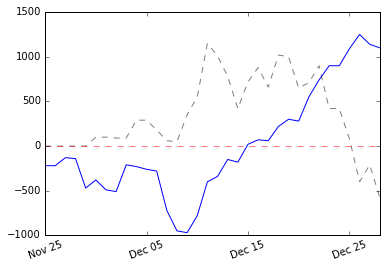

In [78]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

# get cummulative profit
win_agg = numpy.array([sum(win_list[w_start:i]) for i in range(w_start + 1, w_end + 1)])
win_agg_f = numpy.array([sum(win_list_untuned[u_start:i]) for i in range(u_start + 1, u_end + 1)])

# align profit arrays
bet_window_max = max(u_end, w_end)
bet_window_min = min(u_start, w_start)
sigopt_money = numpy.zeros(bet_window_max - bet_window_min)
untuned_money = numpy.zeros(bet_window_max - bet_window_min)
if u_start <= w_start:
    untuned_money[0:u_end - u_start] += win_agg_f
    sigopt_money[w_start - u_start:w_end - u_start] += win_agg
else:
    
    sigopt_money[0:w_end - w_start] += win_agg 
    untuned_money[u_start - w_start:u_end - w_start] += win_agg_f

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sigopt_money, 'b')
ax.plot(untuned_money, 'k--', alpha=0.5)
ax.plot([0, len(win_agg)], [0, 0], 'r--', alpha=0.5)

xticks = list(xrange(0, len(win_agg), 10))
xticklabels = [(SEASON_1516_START + datetime.timedelta(days=t + bet_window_min)).strftime('%b %d') for t in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
plt.xticks(rotation=20)

ax.set_xlim(0,bet_window_max - bet_window_min - 1)